<div class="alert alert-block alert-warning">
Post Revision Notebook - Check out the handsonml git repo for detailed knowledge or just re-read the book!
</div>

# Setup
***

In [37]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the models and scores
import joblib
PROJECT_ROOT_DIR = "."
PROJECT_ID = "mnist"
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", PROJECT_ID)
os.makedirs(MODELS_PATH, exist_ok=True)

# Save models, cross-val accuracy scores, cross-val predictions, and pipelines
def save_model(model, model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    print("Saving model", model_id)
    joblib.dump(model, path)

def load_model(model_id):
    path = os.path.join(MODELS_PATH, model_id + ".pkl")
    return joblib.load(path)

# Get the MNIST Dataset
***

In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [359]:
X, y = mnist["data"], mnist["target"]

In [360]:
X.shape

(70000, 784)

In [361]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

- fairly evenly distributed

## Quick Exploration of Data

In [362]:
some_digit = X[0]

In [363]:
some_digit.shape

(784,)

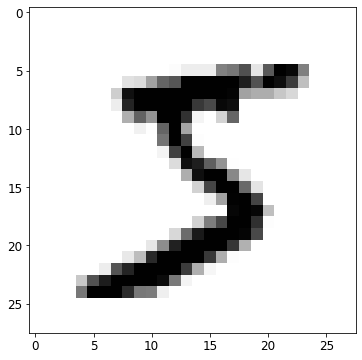

In [364]:
def plot_digit(digit, no_grid=False):
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap=mpl.cm.binary)
    
    if no_grid:
        ticks = range(0,28)
        plt.xticks(ticks); plt.yticks(ticks)

        plt.grid(True)
    
    plt.plot() # jupyter auto plots so this isn't necessary but it also doesn't hurt to add

plt.figure(figsize=(6,6))
plot_digit(some_digit)
plt.show()

In [366]:
y = y.astype(np.uint8)

- saves memory rather than saving as int64

In [367]:
X = X.astype(np.float64)

In [368]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## Creating Train and Test Sets

In [369]:
X_train, X_test = X[:60000, :], X[60000:, :]
y_train, y_test = y[:60000], y[60000:]

# Prepare the Data
***

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [15]:
preparation_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

In [16]:
X_train_prepared = preparation_pipeline.fit_transform(X_train)

# Model Selection
***

In [17]:
# models to test
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

Let's make a function that automates fitting all the models, saving them, calculating their cross-val predictions, saving those, and then returning the model with the highest accuracy.

<div class="alert alert-block alert-warning">
Models already saved.
</div>

In [19]:
model_ids = [
    "sgd_clf",
    "svm_clf",
    "forest_clf",
    "knn_clf",
]

In [38]:
def load_model_data(model_ids):
    model_data = []
    for model_id in model_ids:
        scores = load_model(model_id + "_scores")
        model_data.append((model_id, scores.mean()))
    return model_data

In [21]:
model_data = load_model_data(model_ids)

In [22]:
model_data

[('sgd_clf', 0.8970333333333333),
 ('svm_clf', 0.9601666666666667),
 ('forest_clf', 0.9644833333333334),
 ('knn_clf', 0.9403666666666667)]

- it seems that the random forest classifier is the most accurate
    - but svm, forest, and knn are all pretty close which means we can try fine-tuning all of them
        - it could also mean that it doesn't matter what the model is among the three

However, based on understanding of the algorithms (and hints from handsonml), knn_clf should be the best model suited for this task.
- knn_clf classifies instances based on their proximity to other labeled data. This is great because the data for a '5' should be close to other '5's
    - we just need to tune some hyperparameters like the weight function and number of neighbors to use (more the better?)

# Fine-Tuning
***

In [23]:
from sklearn.model_selection import GridSearchCV

In [29]:
knn_clf = KNeighborsClassifier()

In [62]:
param_grid = [{
    'n_neighbors': [1, 3, 5, 10, 30],
    'weights': ['uniform', 'distance']
}]

grid_search = GridSearchCV(knn_clf, param_grid, scoring="accuracy",
                          cv=5, verbose=2)

In [32]:
grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.5s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.4s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.4s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.9s
[CV] END ....................n_neighbors=1, weights=distance; total time=  14.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.9s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  16.2s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  15.9s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  14.7s
[CV] END ....................n_neighbors=3, weights=distance; total time=  15.4s
[CV] END ....................n_neighbors=3, weights=distance; total time=  15.1s
[CV] END ....................n_neighbors=3, weig

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 3, 5, 10, 30],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=2)

- Since the dataset is rather evenly distributed and also preprocessed, we don't need too many folds for cross-validation

In [36]:
grid_search.best_estimator_

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

- Let's save this model first, then fine_tune around 5 neighbors.

In [39]:
save_model(grid_search.best_estimator_, "knn_clf_model.pkl")

Saving model knn_clf_model.pkl


In [73]:
def print_scores_params(cvres):
    scores, params = cvres["mean_test_score"], cvres["params"]
    s_p = np.c_[scores, params]

    s_p_sorted = s_p[s_p[:, 0].argsort()][::-1]

    for s, p in s_p_sorted:
        print("Score: {:.7f}     Params: {}".format(s, p))

In [42]:
grid_search.best_score_

0.9420999999999999

In [61]:
save_model(cvres, "knn_clf_cvres.pkl")

Saving model knn_clf_cvres.pkl


- this is not much better than our model above... Let's try to fine-tune our n_neighbors more
    - but this time we don't have to adjust the weights, let's set it to `distance`

In [64]:
knn_clf = KNeighborsClassifier(weights="distance")

param_grid = [{
    'n_neighbors': list(range(4, 8)),
}]

grid_search = GridSearchCV(knn_clf, param_grid, scoring="accuracy",
                          cv=5, verbose=1)

In [70]:
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(weights='distance'),
             param_grid=[{'n_neighbors': [4, 5, 6, 7]}], scoring='accuracy',
             verbose=1)

In [74]:
print_scores_params(grid_search.cv_results_)

Score: 0.9465167     Params: {'n_neighbors': 4}
Score: 0.9447167     Params: {'n_neighbors': 6}
Score: 0.9443500     Params: {'n_neighbors': 5}
Score: 0.9423500     Params: {'n_neighbors': 7}


In [77]:
save_model(grid_search.best_estimator_, "knn_clf_model")

Saving model knn_clf_model


In [78]:
save_model(grid_search.cv_results_, "knn_clf_cvres")

Saving model knn_clf_cvres


- Looks like we should try something else to increase the accuracy!

# Data Augmentation
***

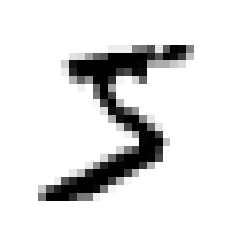

In [79]:
plot_digit(X_train[0])

In [80]:
y_train[0]

5

Let's write a custom data augmentation class that generates four new instances for each digit by shifting the image a pixel left, right, up, and down!

In [265]:
# test shifting
def shift_direction(digit_784, direction, shift_amount):
    digit_square = digit_784.reshape(28, 28)
    
    if direction == "left":
        digit_shifted = digit_square[:, shift_amount:] # get rid of leftmost columns
        digit_square = np.c_[digit_shifted, np.zeros((28, shift_amount))] # add rightmost columns of zeros
    elif direction == "right":
        digit_shifted = digit_square[:, :-shift_amount] # get rid of rightmost columns
        digit_square = np.c_[np.zeros((28, shift_amount)), digit_shifted] # add leftmost columns of zeros
    elif direction == "up":
        digit_shifted = digit_square[shift_amount:, :] # get rid of top columns
        digit_square = np.r_[digit_shifted, np.zeros((shift_amount, 28))] # add bottom columns of zeros
    elif direction == "down":
        digit_shifted = digit_square[:-shift_amount, :] # get rid of bottom columns
        digit_square = np.r_[np.zeros((shift_amount, 28)), digit_shifted] # add top columns of zeros
    else:
        raise ValueError("direction should be one of 'left', 'right', 'up', or 'down'")
    
    return digit_square.reshape(784)

In [266]:
a = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
    ]
)

In [267]:
a[:, :-1]

array([[1, 2],
       [4, 5],
       [7, 8]])

In [268]:
np.r_[a, np.zeros((1, 3))]

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.],
       [0., 0., 0.]])

- can shift left by amount

In [269]:
def compare_shifted(digit, shift_func, direction, shift_amount=1):
    shifted = shift_func(digit, direction, 
                         shift_amount)
    plt.figure(figsize=(8,16))
    plt.subplot(211); plot_digit(digit)
    plt.subplot(212); plot_digit(shifted)

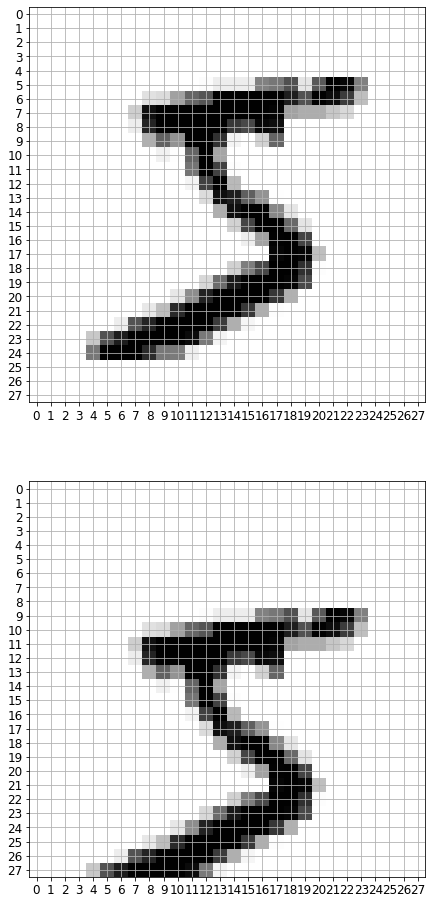

In [270]:
compare_shifted(X_train[0], shift_direction, "down", shift_amount=4)

In [278]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomDigitShifter(BaseEstimator, TransformerMixin):
    def __init__(self, shift_amount=1):
        self.shift_amount = shift_amount
    def fit(self, X, y=None):
        pass
    def transform(self, X, y):
        num_rows = X.shape[0]
        
        for row in range(0, num_rows):
            digit = X[row, :]
            np.vstack((X, shift_direction(digit, "left", self.shift_amount)))
            np.vstack((X, shift_direction(digit, "right", self.shift_amount)))
            np.vstack((X, shift_direction(digit, "up", self.shift_amount)))
            np.vstack((X, shift_direction(digit, "down", self.shift_amount)))
            np.append(y, np.full(4, y[row]))
        
        return (X, y)

In [ ]:
# digit_shifter = CustomDigitShifter()
# X_train_aug, y_train_aug = digit_shifter.transform(X_train, y_train)

- my own method is too slow and unoptimized, let's use prebuilt libraries for this

In [280]:
from scipy.ndimage.interpolation import shift

In [281]:
some_digit = X_train[0]

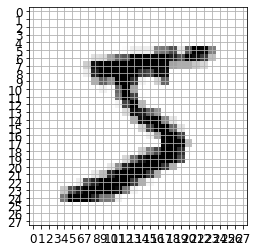

In [282]:
plot_digit(some_digit)

In [286]:
shifted_digit = shift(some_digit.reshape((28,28)), [-5, 5]).reshape([-1])

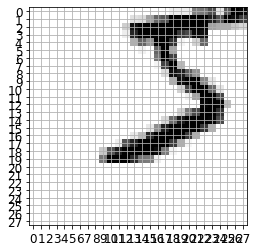

In [287]:
plot_digit(shifted_digit)

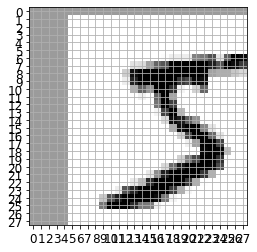

In [300]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [301]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [302]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [303]:
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)

knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [304]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [306]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_expanded_pred)

0.9763